In [17]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torchvision import transforms


Loading the data

In [18]:
Kmnist = fetch_openml('Kuzushiji-MNIST', cache=False)

In [19]:
Kmnist.data.shape

(70000, 784)

Preprocessing Data

In [20]:
X = Kmnist.data.astype('float32')
y = Kmnist.target.astype('int64')

In [21]:
X /= 255.0
# Convert pandas dataframe to numpy array
X = X.to_numpy()

In [22]:
X.min(), X.max()

(0.0, 1.0)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Exploring the data

In [24]:
print('Number of training images:',X_train.shape[0])
print('Number of test images:',X_test.shape[0])


Number of training images: 52500
Number of test images: 17500


Displaying a few images

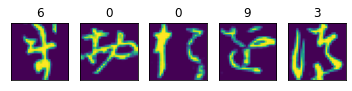

In [25]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
plot_example(X_train, y_train)

Exploratory data analysis

In [26]:
train_labels_count = np.unique(y_train, return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5261
1,1,5263
2,2,5246
3,3,5232
4,4,5297
5,5,5157
6,6,5280
7,7,5226
8,8,5298
9,9,5240


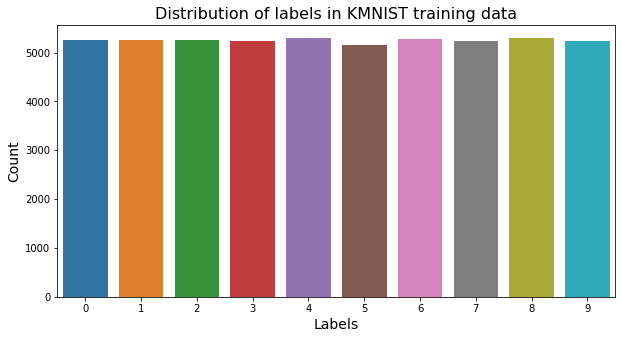

In [27]:
# Get the unique labels
labels = np.unique(y_train)

# Get the frequency count for each label
frequency_count = np.bincount(y_train)

# Visualize 
plt.figure(figsize=(10,5))
sns.barplot(x=labels, y=frequency_count);
plt.title("Distribution of labels in KMNIST training data", fontsize=16)
plt.xlabel("Labels", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [28]:
# Labels mapping
labels_dict = dict([(0, u"\u304A"), (1, u"\u304D"), (2, u"\u3059"), (3, u"\u3064"),
                    (4, u"\u306A"), (5, u"\u306F"), (6, u"\u307E"), (7, u"\u3084"),
                    (8, u"\u308C"), (9, u"\u3093")])

print(labels_dict)

{0: 'お', 1: 'き', 2: 'す', 3: 'つ', 4: 'な', 5: 'は', 6: 'ま', 7: 'や', 8: 'れ', 9: 'ん'}


Creating the model

SOM

In [29]:
def create_grid_image(N, nodes, resolution=8):
    map_image = np.zeros((N*28, N*28))
    som_node_grid = nodes.reshape(N, N, -1)
    for i, row in enumerate(som_node_grid):
        for j, unit in enumerate(row):
            map_image[i * 28:(i + 1)*28, j*28:(j+1)*28] = unit.reshape(28,28)
    return map_image

In [30]:
# Buding SOM model
# Source:  https://github.com/Teitei011/SOM_MNIST/blob/master/SOM_MNIST.ipynb
class SOM():
    def __init__(self, teachers, N, seed=None):
        self.teachers = np.array(teachers)
        self.n_teacher = self.teachers.shape[0]
        self.N = N
        if not seed is None:
            np.random.seed(seed)
            
        x, y = np.meshgrid(range(self.N), range(self.N))
        self.c = np.hstack((x.flatten()[:, np.newaxis],
                            y.flatten()[:, np.newaxis]))
        self.nodes = np.random.rand(self.N * self.N, self.teachers.shape[1])
    
    def train(self):
        for i, teacher in enumerate(self.teachers):
            bmu = self._best_matching_unit(teacher)
            d = np.linalg.norm(self.c - bmu, axis=1)
            L = self._learning_ratio(i)
            S = self._learning_radius(i, d)
            self.nodes += L * S[:, np.newaxis] * (teacher - self.nodes)
        return self.nodes

    def _best_matching_unit(self, teacher):
        #compute all norms (square)
        norms = np.linalg.norm(self.nodes - teacher, axis=1)
        bmu = np.argmin(norms) #argment with minimum element 
        return np.unravel_index(bmu,(self.N, self.N))

    def _neighbourhood(self, t):#neighbourhood radious
        halflife = float(self.n_teacher / 4.) #for testing
        initial  = float(self.N / 2.)
        return initial*np.exp(-t/halflife)

    def _learning_ratio(self, t):
        halflife = float(self.n_teacher / 4.) #for testing
        initial  = 0.1
        return initial*np.exp(-t/halflife)

    def _learning_radius(self, t, d):
        # d is distance from BMU
        s = self._neighbourhood(t)
        return np.exp(-d**2/(2*s**2))

In [31]:
N = 20
teachers = X_train.reshape(-1, 28*28)
som = SOM(teachers, N=N, seed=10)

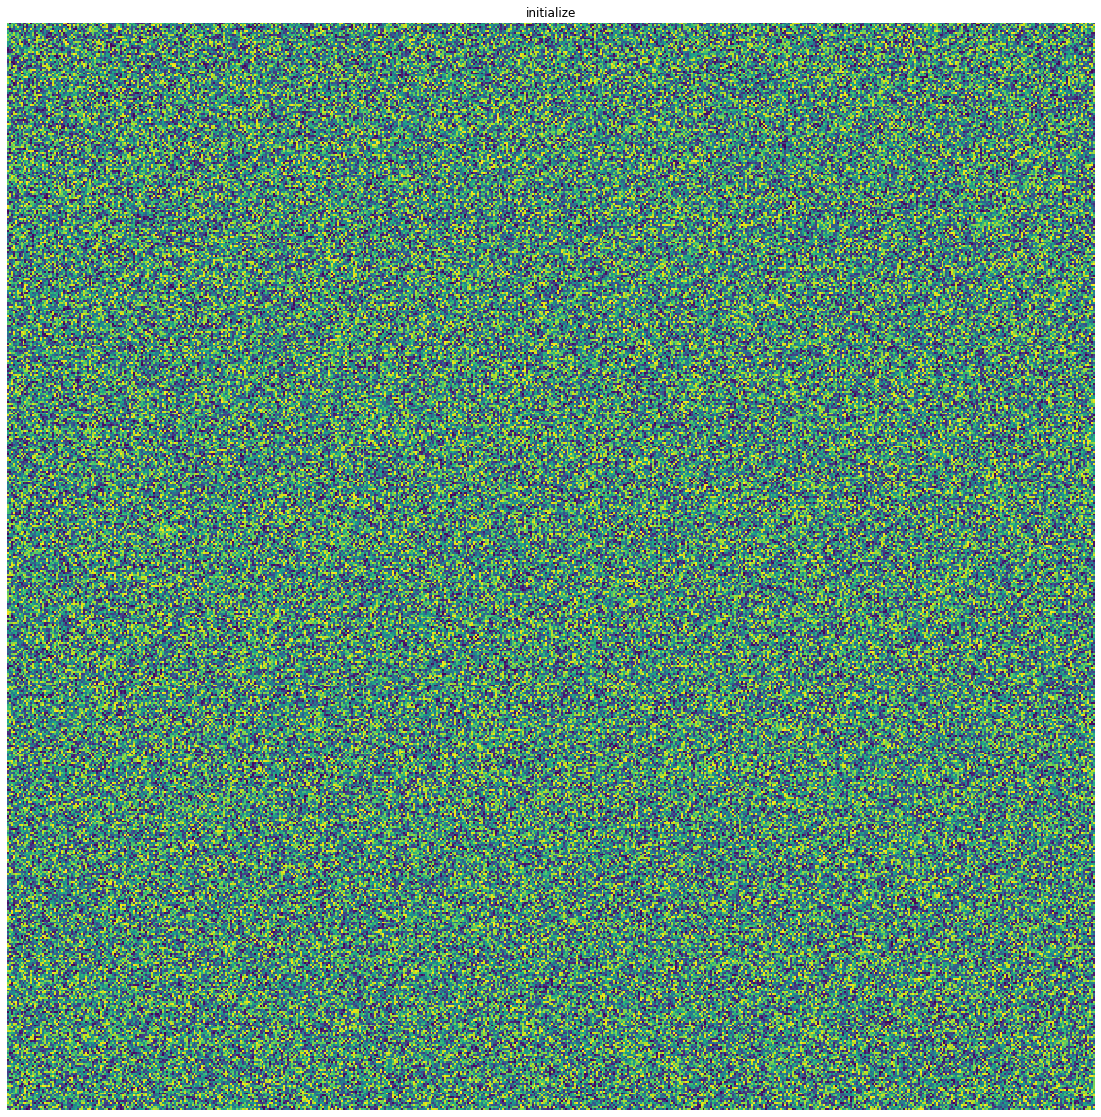

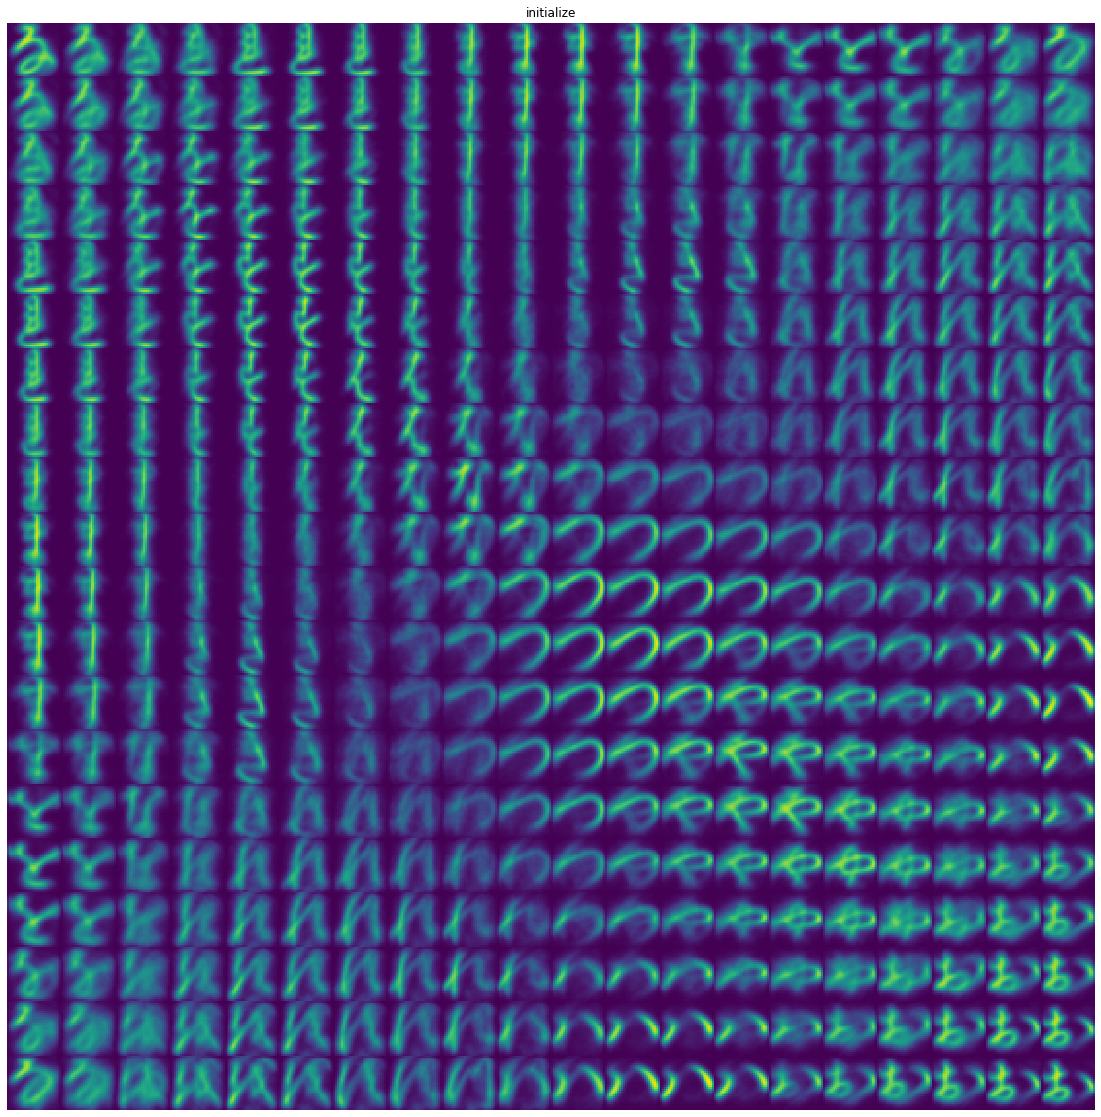

[INFO] It took 132.59643483161926 seconds


In [34]:
import time
start = time.time()

map_image = create_grid_image(N, som.nodes, resolution=28)
plt.figure(figsize=(20,20))
plt.title('initialize')
plt.axis('off')
plt.imshow(map_image ,interpolation='none')
plt.show()

# Train
som.train()

map_image = create_grid_image(N, som.nodes, resolution=28)
plt.figure(figsize=(20,20))
plt.title('initialize')
plt.axis('off')
plt.imshow(map_image ,interpolation='none')
plt.show()

print("[INFO] It took {} seconds".format(time.time() - start))


RBM

In [35]:

%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

In [36]:
def gen_mnist_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)

In [37]:
X_train = (X_train - np.min(X_train, 0)) / (np.max(X_train, 0) + 0.0001)  # 0-1 scaling


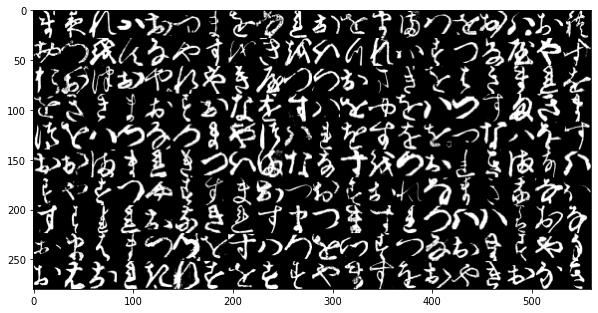

In [38]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(X_train));

In [ ]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components=100, learning_rate=0.01, random_state=0, verbose=True)
rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -214.73, time = 12.53s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -195.66, time = 20.87s


In [ ]:
BernoulliRBM(batch_size=10, learning_rate=0.01, n_components=100, n_iter=10,
       random_state=0, verbose=True)

In [ ]:
xx = X_train[:40].copy()
for ii in range(1000):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

In [ ]:
BernoulliRBM(batch_size=5, learning_rate=0.008, n_components=150, n_iter=100,
       random_state=0, verbose=True)

In [ ]:
xx = X_train[:40].copy()
for ii in range(10000):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(gen_mnist_image(xx))

In [ ]:
plt.figure(figsize=(20, 20))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.RdBu,
               interpolation='nearest', vmin=-2.5, vmax=2.5)
    plt.axis('off')
plt.suptitle('100 components extracted by RBM', fontsize=16);

In [ ]:
classifier = BernoulliRBM(batch_size=5, learning_rate=0.008, n_components=150, n_iter=100,
       random_state=0, verbose=True)
classifier.fit(X_train, y_train)